In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from time import clock
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict
#from helpers import cluster_acc, myGMM,nn_arch,nn_reg
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import sys
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
# load HR dataset
HR_PATH = "/Users/shuyi/Documents/OMSCS/MachineLearning/HW1/HRData/"
TRAIN_DATA_FILE = "train_x_selected.csv"
data_hr = pd.read_csv(HR_PATH+TRAIN_DATA_FILE)

In [4]:
data_hr.shape

(14999, 21)

In [5]:
del data_hr['Unnamed: 0']
data_hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [6]:
data_hr.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'sales_IT', 'sales_RandD', 'sales_accounting',
       'sales_hr', 'sales_management', 'sales_marketing', 'sales_product_mng',
       'sales_sales', 'sales_support', 'sales_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

In [7]:
train_y_hr = data_hr["satisfaction_level"]
train_x_hr = data_hr.copy().drop(["satisfaction_level"], 1)

In [10]:
clusters =  [2,5,10,15,20,25,30,35,40,45,50]

In [29]:
SSE = defaultdict(dict)
ll = defaultdict(dict)
acc = defaultdict(lambda: defaultdict(dict))
adjMI = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=5)
gmm = GMM(random_state=5) # Gaussian Matrix

In [12]:
def cluster_acc(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
    return acc(Y,pred)

In [45]:
st = clock()
for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(train_x_hr)
    # Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
    gmm.fit(train_x_hr)
    SSE[k]['HR'] = km.score(train_x_hr)
    ll[k]['HR'] = gmm.score(train_x_hr)    
    adjMI[k]['HR']['Kmeans'] = ami(train_y_hr,km.predict(train_x_hr))
    adjMI[k]['HR']['GMM'] = ami(train_y_hr,gmm.predict(train_x_hr))
    print(k, clock()-st)
    

2 0.27176800000000156
5 1.0764840000000007
10 2.601652999999999
15 5.326219999999999
20 9.511294999999997
25 14.906908999999999
30 20.662168
35 29.339870999999995
40 38.38048799999999
45 50.261162000000006
50 67.26723899999999


In [46]:
SSE = (-pd.DataFrame(SSE)).T
SSE.rename(columns = lambda x: x+' SSE (left)',inplace=True)
ll = pd.DataFrame(ll).T
ll.rename(columns = lambda x: x+' log-likelihood',inplace=True)
adjMI = pd.Panel(adjMI)

In [70]:
SSE

,HR SSE (left)
2,8.873111e+06
5,1.987998e+06
10,5.648343e+05
15,2.889723e+05
20,1.970619e+05
25,1.522039e+05
30,1.269121e+05
35,1.130036e+05
40,1.050021e+05
45,9.670240e+04


In [30]:
# use different random seed for Kmeans and EM to plot the results
seeds = [0,10,20,30]
for s in seeds:
    for k in clusters:
        km.set_params(n_clusters=k, random_state=s)
        gmm.set_params(n_components=k, random_state=s)
        km.fit(train_x_hr)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        gmm.fit(train_x_hr)
        SSE[k]['HR'+str(s)] = km.score(train_x_hr)
        ll[k]['HR'+str(s)] = gmm.score(train_x_hr)    
        adjMI[k]['HR']['Kmeans'+str(s)] = ami(train_y_hr,km.predict(train_x_hr))
        adjMI[k]['HR']['GMM'+str(s)] = ami(train_y_hr,gmm.predict(train_x_hr))


In [31]:
SSE = (-pd.DataFrame(SSE)).T
#SSE.rename(columns = lambda x: str(x),inplace=True)
ll = pd.DataFrame(ll).T
#ll.rename(columns = lambda x: str(x) +' log-likelihood',inplace=True)
#adjMI = pd.Panel(adjMI)

In [49]:
ll

,HR0,HR10,HR20,HR30
2,12.154638,12.155807,12.154638,12.155807
5,45.791451,42.580190,36.344827,43.346612
10,51.756695,48.030886,52.070513,54.384709
15,58.076999,54.702195,60.991400,58.602628
20,60.055426,62.734298,61.321038,62.944059
25,62.855594,66.293027,61.513398,65.082584
30,64.276272,65.686967,65.135161,64.619939
35,65.536326,64.779006,66.769272,62.913847
40,67.384717,64.711623,67.471589,66.042858
45,66.413126,68.682241,65.713966,67.762010


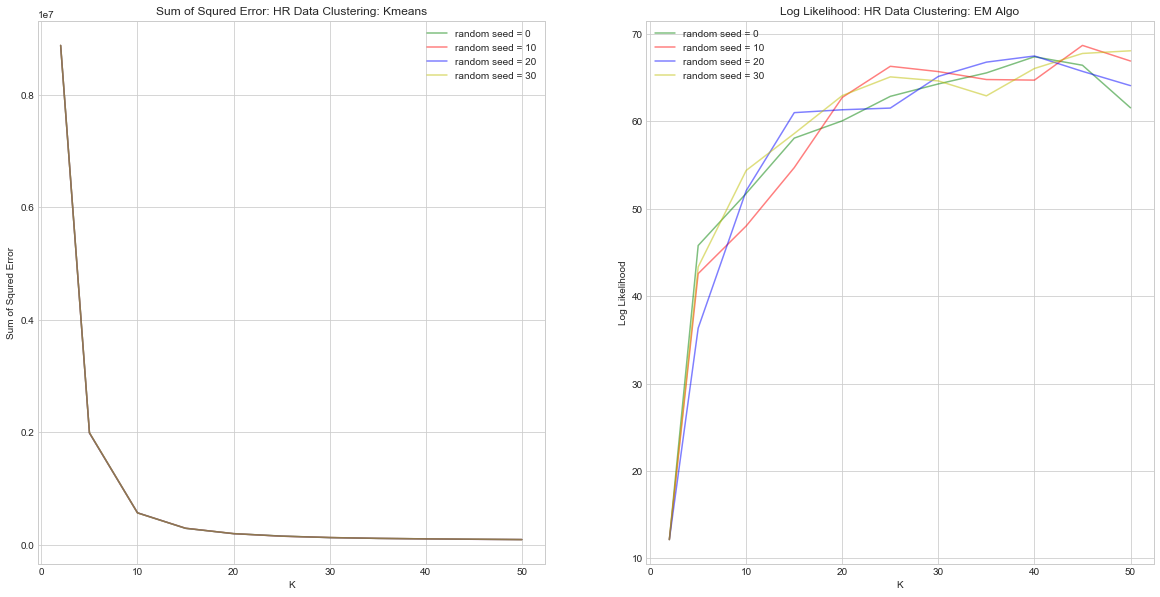

In [54]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, SSE['HR0'], color="g", alpha=0.5, label='random seed = 0')
plt.plot(clusters, SSE['HR10'], color = 'r', alpha = 0.5, label='random seed = 10')
plt.plot(clusters, SSE['HR20'], color="b", alpha=0.5, label='random seed = 20')
plt.plot(clusters, SSE['HR30'], color="y", alpha=0.5, label='random seed = 30')
plt.legend()
plt.title("Sum of Squred Error: HR Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Sum of Squred Error")

plt.subplot(122)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, ll['HR0'], color="g", alpha=0.5, label='random seed = 0')
plt.plot(clusters, ll['HR10'], color = 'r', alpha = 0.5, label='random seed = 10')
plt.plot(clusters, ll['HR20'], color="b", alpha=0.5, label='random seed = 20')
plt.plot(clusters, ll['HR30'], color="y", alpha=0.5,label='random seed = 30')
plt.legend()
plt.title("Log Likelihood: HR Data Clustering: EM Algo")
plt.xlabel("K")
plt.ylabel("Log Likelihood")


plt.show()


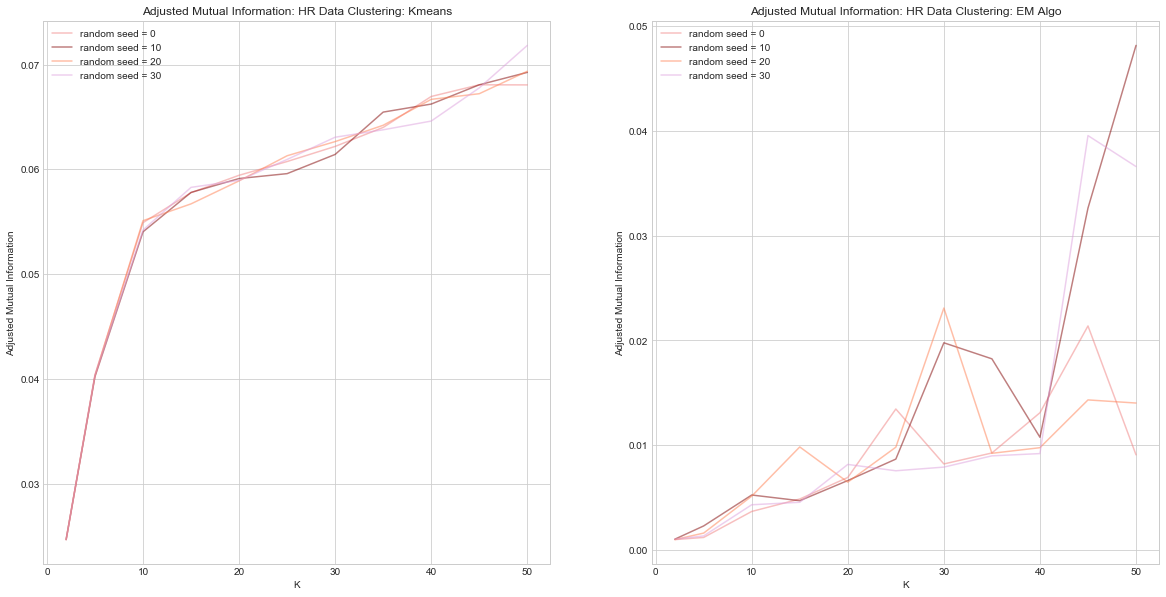

In [57]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
adj_k0 = []
adj_k10 = []
adj_k20 = []
adj_k30 = []
for k in clusters:
    adj_k0.append(adjMI[k]['HR']['Kmeans0'])
    adj_k10.append(adjMI[k]['HR']['Kmeans10'])
    adj_k20.append([adjMI[k]['HR']['Kmeans20']])
    adj_k30.append([adjMI[k]['HR']['Kmeans30']])
plt.plot(clusters, adj_k0, color="lightcoral", alpha=0.5, label='random seed = 0')
plt.plot(clusters, adj_k10, color = 'maroon', alpha = 0.5, label='random seed = 10')
plt.plot(clusters, adj_k20, color="coral", alpha=0.5, label='random seed = 20')
plt.plot(clusters, adj_k30, color="plum", alpha=0.5, label='random seed = 30')
plt.legend()
plt.title("Adjusted Mutual Information: HR Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Adjusted Mutual Information")

plt.subplot(122)
adj_em0 = []
adj_em10 = []
adj_em20 = []
adj_em30 = []
for k in clusters:
    adj_em0.append(adjMI[k]['HR']['GMM0'])
    adj_em10.append(adjMI[k]['HR']['GMM10'])
    adj_em20.append([adjMI[k]['HR']['GMM20']])
    adj_em30.append([adjMI[k]['HR']['GMM30']])

plt.plot(clusters, adj_em0, color="lightcoral", alpha=0.5, label='random seed = 0')
plt.plot(clusters, adj_em10, color = 'maroon', alpha = 0.5, label='random seed = 10')
plt.plot(clusters, adj_em20, color="coral", alpha=0.5, label='random seed = 20')
plt.plot(clusters, adj_em30, color="plum", alpha=0.5,label='random seed = 30')
plt.legend()
plt.title("Adjusted Mutual Information: HR Data Clustering: EM Algo")
plt.xlabel("K")
plt.ylabel("Adjusted Mutual Information")


plt.show()


In [91]:
# visualize the EM algo
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])

def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #plt.xlim(-6., 4. * np.pi - 6.)
    #plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

Automatically created module for IPython interactive environment


/Users/shuyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/Users/shuyi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


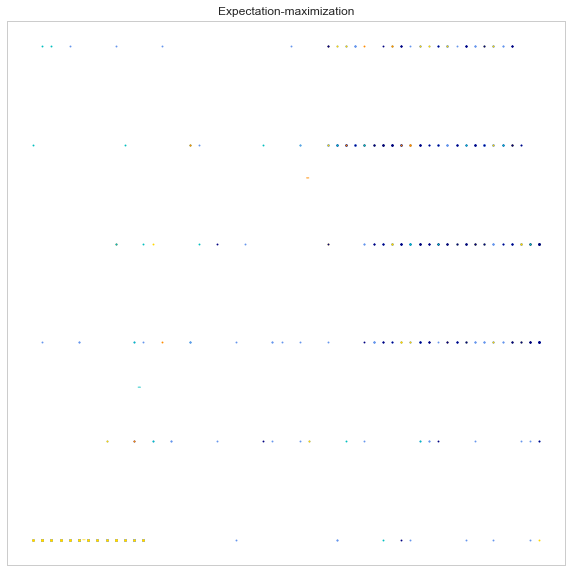

In [100]:
plt.figure(figsize=(10, 10))
temp = train_x_hr[:1000].as_matrix()
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full',
                              max_iter=100).fit(temp)
plot_results(temp, gmm.predict(temp), gmm.means_, gmm.covariances_, 0,
             'Expectation-maximization')
plt.show()

In [65]:
# visulize K-means
# Step size of the mesh. Decrease to increase the quality of the VQ.
def plotKmeans(h, km, data):
    #h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the HR dataset\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [ ]:
plotKmeans(0.1, km, train_x_hr[['last_evaluation', 'number_project',
       'average_montly_hours']].as_matrix())

Dimension Reduction


1. PCA

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from helpers import  nn_arch,nn_reg
from matplotlib import cm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [67]:
out = './PCA/'
cmap = cm.get_cmap('Spectral') 
np.random.seed(0)
#raise
#%% data for 1

pca = PCA(random_state=5, n_components=19)
pca.fit(train_x_hr)
tmp = pd.Series(data = pca.explained_variance_,index = range(1,20))
#tmp.to_csv(out+'madelon scree.csv')
tmp

1     2.494616e+03
2     2.172052e+00
3     1.183580e+00
4     4.568997e-01
5     2.371317e-01
6     1.644420e-01
7     1.239460e-01
8     1.189101e-01
9     1.078992e-01
10    7.376266e-02
11    5.893790e-02
12    5.498426e-02
13    5.170274e-02
14    4.985887e-02
15    4.041246e-02
16    2.424410e-02
17    1.984153e-02
18    1.310015e-32
19    5.581237e-33
dtype: float64

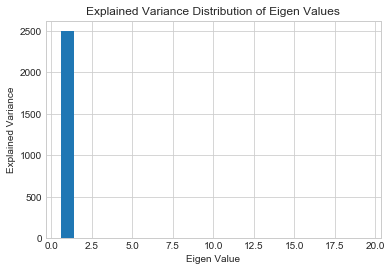

In [83]:
plt.figure()
plt.bar(np.arange(1,20,1),tmp, align='center')
plt.ylabel('Explained Variance')
plt.xlabel('Eigen Value')
plt.title('Explained Variance Distribution of Eigen Values')
plt.show()

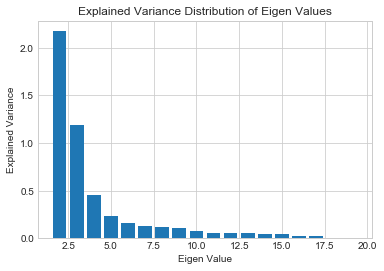

In [93]:
plt.figure()
plt.bar(np.arange(2,20),tmp[1:], align='center')
plt.ylabel('Explained Variance')
plt.xlabel('Eigen Value')
plt.title('Explained Variance Distribution of Eigen Values')
plt.show()

In [92]:
tmp[1:]

2     2.172052e+00
3     1.183580e+00
4     4.568997e-01
5     2.371317e-01
6     1.644420e-01
7     1.239460e-01
8     1.189101e-01
9     1.078992e-01
10    7.376266e-02
11    5.893790e-02
12    5.498426e-02
13    5.170274e-02
14    4.985887e-02
15    4.041246e-02
16    2.424410e-02
17    1.984153e-02
18    1.310015e-32
19    5.581237e-33
dtype: float64

In [72]:
dims = [2,4,6,9,12,14,16,19]
SSE_PCA = defaultdict(dict)
ll_PCA = defaultdict(dict)
#acc = defaultdict(lambda: defaultdict(dict))
adjMI_PCA = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=10)
gmm = GMM(random_state=10)
km.set_params(n_clusters=40, random_state=10)
gmm.set_params(n_components=40, random_state=10)
    
for d in dims:
    reduced_hr_data = PCA(n_components=d).fit_transform(train_x_hr)
    km.fit(reduced_hr_data)
    #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
    gmm.fit(reduced_hr_data)
    SSE_PCA[d]['HR'] = km.score(reduced_hr_data)
    ll_PCA[d]['HR'] = gmm.score(reduced_hr_data)    
    adjMI_PCA[d]['HR']['Kmeans'] = ami(train_y_hr,km.predict(reduced_hr_data))
    adjMI_PCA[d]['HR']['GMM'] = ami(train_y_hr,gmm.predict(reduced_hr_data))


In [74]:
SSE_PCA = (-pd.DataFrame(SSE)).T
#SSE.rename(columns = lambda x: str(x),inplace=True)
ll_PCA = pd.DataFrame(ll).T
SSE_PCA

,HR
2,62999.388912
4,86844.937992
6,93702.961888
9,97792.382881
12,101444.631589
14,101834.782605
16,103864.865083
19,103853.397963


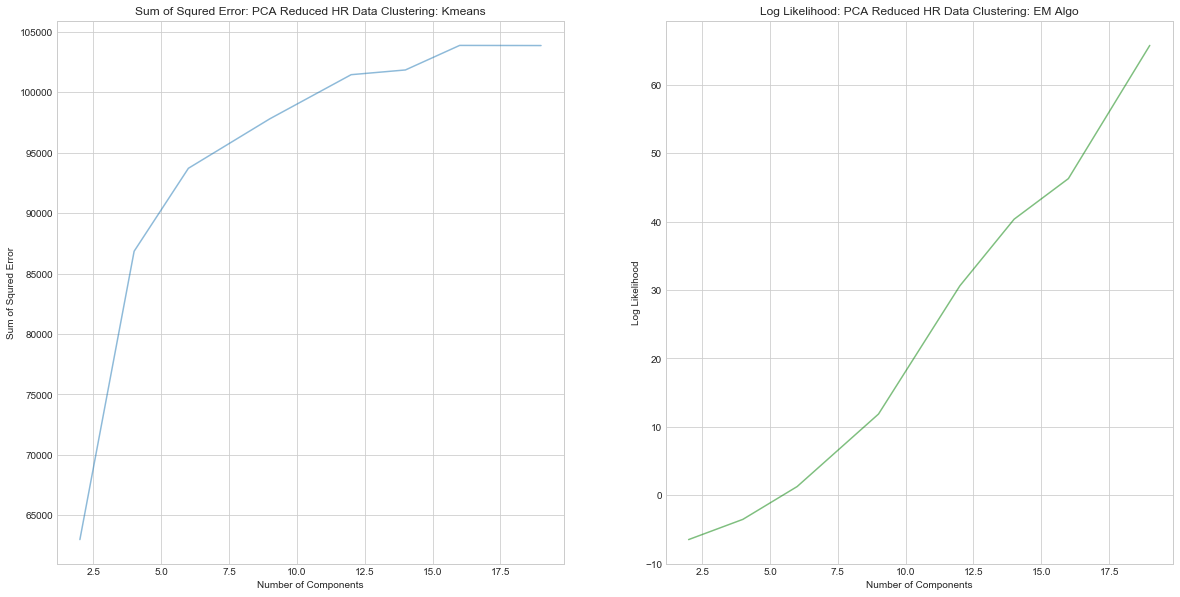

In [78]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(dims, SSE_PCA['HR'],  alpha=0.5)
plt.title("Sum of Squred Error: PCA Reduced HR Data Clustering: Kmeans")
plt.xlabel("Number of Components")
plt.ylabel("Sum of Squred Error")

plt.subplot(122)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(dims, ll_PCA['HR'], color="g", alpha=0.5)
plt.title("Log Likelihood: PCA Reduced HR Data Clustering: EM Algo")
plt.xlabel("Number of Components")
plt.ylabel("Log Likelihood")


plt.show()


In [ ]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
adj_k0 = []
adj_k10 = []
adj_k20 = []
adj_k30 = []
for k in clusters:
    adj_k0.append(adjMI[k]['HR']['Kmeans0'])
    adj_k10.append(adjMI[k]['HR']['Kmeans10'])
    adj_k20.append([adjMI[k]['HR']['Kmeans20']])
    adj_k30.append([adjMI[k]['HR']['Kmeans30']])
plt.plot(clusters, adj_k0, color="lightcoral", alpha=0.5, label='random seed = 0')
plt.plot(clusters, adj_k10, color = 'maroon', alpha = 0.5, label='random seed = 10')
plt.plot(clusters, adj_k20, color="coral", alpha=0.5, label='random seed = 20')
plt.plot(clusters, adj_k30, color="plum", alpha=0.5, label='random seed = 30')
plt.legend()
plt.title("Adjusted Mutual Information: HR Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Adjusted Mutual Information")

plt.subplot(122)
adj_em0 = []
adj_em10 = []
adj_em20 = []
adj_em30 = []
for k in clusters:
    adj_em0.append(adjMI[k]['HR']['GMM0'])
    adj_em10.append(adjMI[k]['HR']['GMM10'])
    adj_em20.append([adjMI[k]['HR']['GMM20']])
    adj_em30.append([adjMI[k]['HR']['GMM30']])

plt.plot(clusters, adj_em0, color="lightcoral", alpha=0.5, label='random seed = 0')
plt.plot(clusters, adj_em10, color = 'maroon', alpha = 0.5, label='random seed = 10')
plt.plot(clusters, adj_em20, color="coral", alpha=0.5, label='random seed = 20')
plt.plot(clusters, adj_em30, color="plum", alpha=0.5,label='random seed = 30')
plt.legend()
plt.title("Adjusted Mutual Information: HR Data Clustering: EM Algo")
plt.xlabel("K")
plt.ylabel("Adjusted Mutual Information")


plt.show()


In [95]:
SSE_pca = defaultdict(dict)
ll_pca = defaultdict(dict)
#adjMI_pca = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=10)
gmm = GMM(random_state=10) # Gaussian Matrix
km_pca = kmeans(random_state=10)
gmm_pca = GMM(random_state=10) # Gaussian Matrix

d = 5
reduced_hr_data = PCA(n_components=d).fit_transform(train_x_hr)
for k in clusters:
        km.set_params(n_clusters=k, random_state=10)
        km_pca.set_params(n_clusters=k, random_state=10)
        gmm.set_params(n_components=k, random_state=10)
        gmm_pca.set_params(n_components=k, random_state=10)
        
        km.fit(train_x_hr)
        km_pca.fit(reduced_hr_data)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        gmm.fit(train_x_hr)
        gmm_pca.fit(reduced_hr_data)
        SSE_pca[k]['original'] = km.score(train_x_hr)
        SSE_pca[k]['pca'] = km_pca.score(reduced_hr_data)
        ll_pca[k]['original'] = gmm.score(train_x_hr) 
        ll_pca[k]['pca'] = gmm_pca.score(reduced_hr_data)    



In [97]:
SSE_pca = (-pd.DataFrame(SSE_pca)).T
#SSE_pca.rename(columns = lambda x: x+' SSE (left)',inplace=True)
ll_pca = pd.DataFrame(ll_pca).T
#ll_pca.rename(columns = lambda x: x+' log-likelihood',inplace=True)

In [101]:
ll_pca

,original,pca
2,12.155807,-10.082846
5,42.580190,-9.186789
10,48.030886,-5.801976
15,54.702195,-5.108836
20,62.734298,-4.637256
25,66.293027,-4.037783
30,65.686967,-3.178538
35,64.779006,-3.006727
40,64.711623,-1.772130
45,68.682241,-0.945061


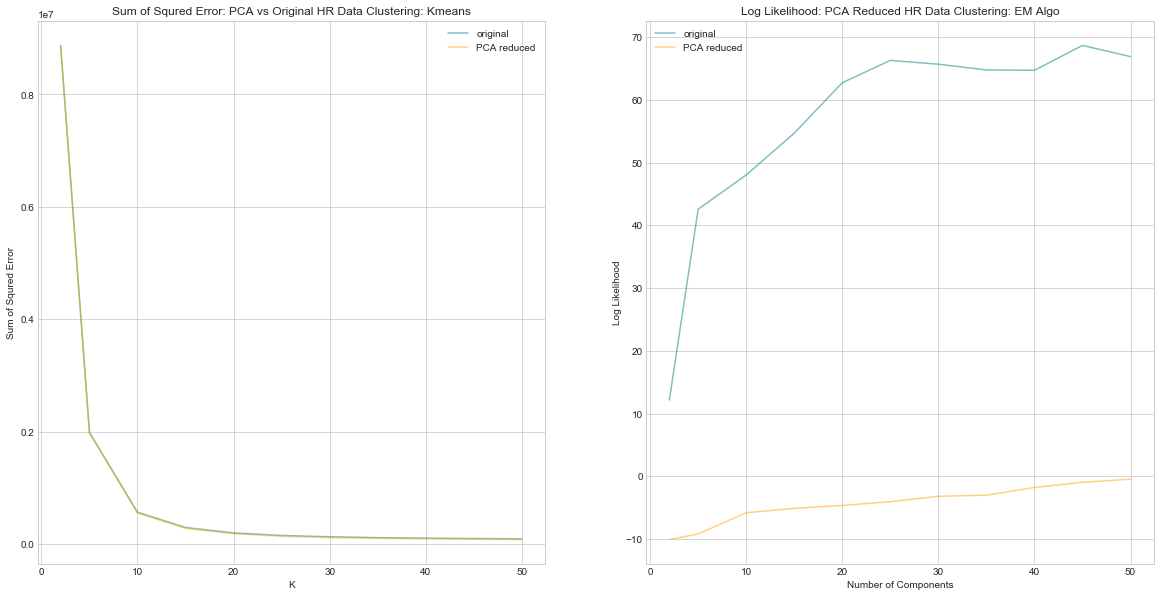

In [108]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, SSE_pca['original'],  alpha=0.5, label = 'original', color = 'teal')
plt.plot(clusters, SSE_pca['pca'],  alpha=0.5, label = 'PCA reduced', color = 'orange')
plt.title("Sum of Squred Error: PCA vs Original HR Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Sum of Squred Error")
plt.legend()
plt.subplot(122)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, ll_pca['original'], alpha=0.5, label = 'original', color = 'teal')
plt.plot(clusters, ll_pca['pca'], alpha=0.5, label = 'PCA reduced', color = 'orange')
plt.title("Log Likelihood: PCA Reduced HR Data Clustering: EM Algo")
plt.xlabel("Number of Components")
plt.ylabel("Log Likelihood")
plt.legend()

plt.show()


2.ICA

In [120]:
from sklearn.decomposition import FastICA
from scipy import stats as ss

In [110]:
ica = FastICA(n_components=5)
S = ica.fit_transform(train_x_hr)  # Reconstruct signals

In [114]:
# local max, we need to max kurtosis of wTx
A = ica.mixing_

In [121]:
ss.kurtosis(S, axis=0)

array([-1.06686885, -1.89182217, -1.1370647 ,  5.64395358, -0.53715303])

In [123]:
sum(abs(ss.kurtosis(S, axis=0)))

10.276862333878846

In [125]:
kurt = {}
for d in dims:
    ica.set_params(n_components=d)
    tmp = ica.fit_transform(train_x_hr)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt[d] = tmp.abs().mean()

kurt = pd.Series(kurt) 
#kurt.to_csv(out+'madelon scree.csv')

/Users/shuyi/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/shuyi/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/shuyi/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [126]:
kurt

2     2.541805
4     2.302801
6     1.713149
9     2.602684
12    4.246283
14    6.390836
16    7.098632
19    2.581017
dtype: float64

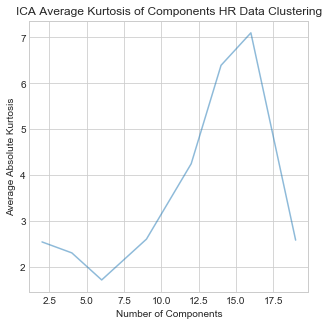

In [128]:
plt.figure(figsize=(5,5))
#sns.set_style("whitegrid")
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(dims, kurt,  alpha=0.5)
plt.title("ICA Average Kurtosis of Components HR Data Clustering")
plt.xlabel("Number of Components")
plt.ylabel("Average Absolute Kurtosis")



plt.show()

In [129]:
# kmeans and EM for ICA
# choose component = 6
ica = FastICA(n_components=6)
S = ica.fit_transform(train_x_hr)

In [131]:
SSE_ica = defaultdict(dict)
ll_ica = defaultdict(dict)
#adjMI_pca = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=10)
gmm = GMM(random_state=10) # Gaussian Matrix
km_ica = kmeans(random_state=10)
gmm_ica = GMM(random_state=10) # Gaussian Matrix

for k in clusters:
        km.set_params(n_clusters=k, random_state=10)
        km_ica.set_params(n_clusters=k, random_state=10)
        gmm.set_params(n_components=k, random_state=10)
        gmm_ica.set_params(n_components=k, random_state=10)
        
        km.fit(train_x_hr)
        km_ica.fit(S)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        gmm.fit(train_x_hr)
        gmm_ica.fit(S)
        SSE_ica[k]['original'] = km.score(train_x_hr)
        SSE_ica[k]['ica'] = km_ica.score(S)
        ll_ica[k]['original'] = gmm.score(train_x_hr) 
        ll_ica[k]['ica'] = gmm_ica.score(S)    



In [134]:
SSE_ica = (-pd.DataFrame(SSE_ica)).T
#SSE_pca.rename(columns = lambda x: x+' SSE (left)',inplace=True)
ll_ica = pd.DataFrame(ll_ica).T

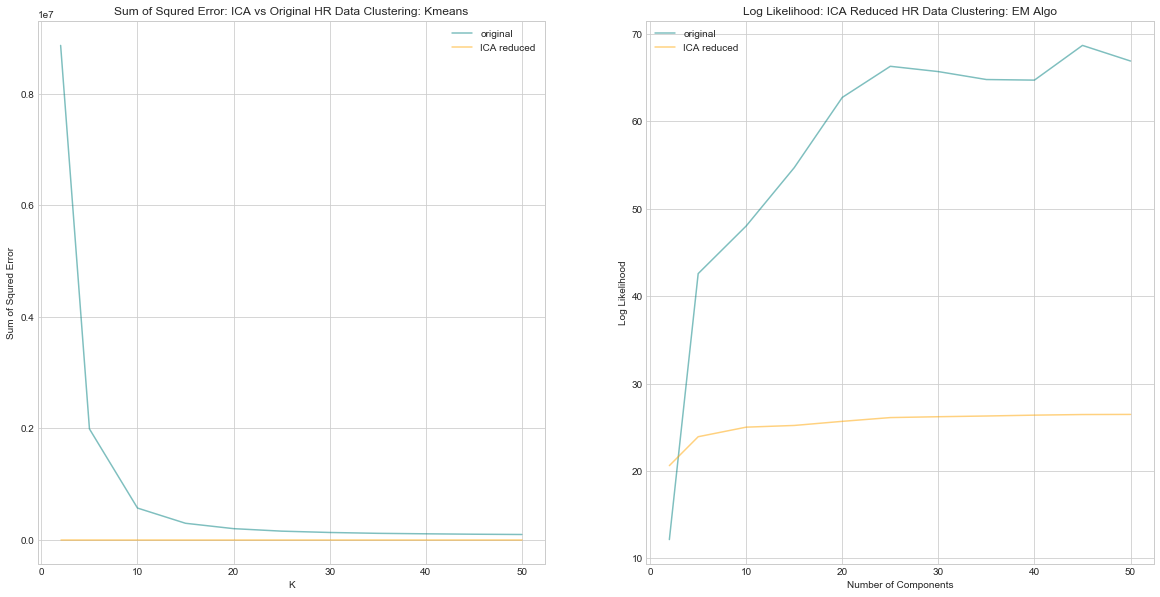

In [135]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, SSE_ica['original'],  alpha=0.5, label = 'original', color = 'teal')
plt.plot(clusters, SSE_ica['ica'],  alpha=0.5, label = 'ICA reduced', color = 'orange')
plt.title("Sum of Squred Error: ICA vs Original HR Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Sum of Squred Error")
plt.legend()
plt.subplot(122)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, ll_ica['original'], alpha=0.5, label = 'original', color = 'teal')
plt.plot(clusters, ll_ica['ica'], alpha=0.5, label = 'ICA reduced', color = 'orange')
plt.title("Log Likelihood: ICA Reduced HR Data Clustering: EM Algo")
plt.xlabel("Number of Components")
plt.ylabel("Log Likelihood")
plt.legend()

plt.show()

3. Random Projection

In [137]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from itertools import product
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score as acc
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.base import TransformerMixin,BaseEstimator
import scipy.sparse as sps
from scipy.linalg import pinv

In [138]:
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

In [139]:
tmp = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(train_x_hr), train_x_hr)
tmp =pd.DataFrame(tmp).T

In [141]:
tmp

,0,1,2,3,4,5,6,7,8,9
2,0.166164,0.998824,0.010214,0.998922,0.013170,0.999733,0.999636,0.105583,0.003080,0.019814
4,0.151683,0.998799,0.011387,0.999763,0.090253,0.999678,0.999631,0.999827,0.129931,0.019980
6,0.999046,0.998802,0.999726,0.999857,0.999600,0.999768,0.999641,0.999810,0.120633,0.071923
9,0.999037,0.999645,0.999720,0.999841,0.999602,0.999672,0.999733,0.999944,0.999777,0.999669
12,0.999172,0.999647,0.999664,0.999883,0.999802,0.999933,0.999751,0.999921,0.999841,0.999637
14,0.999871,0.999661,0.999922,0.999935,0.999775,0.999907,0.999686,0.999841,0.999774,0.999741
16,0.999157,0.999625,0.999918,0.999917,0.999771,0.999969,0.999692,0.999830,0.999776,0.999602
19,0.999883,0.999632,0.999914,0.999790,0.999863,0.999916,0.999748,0.999817,0.999858,0.999555


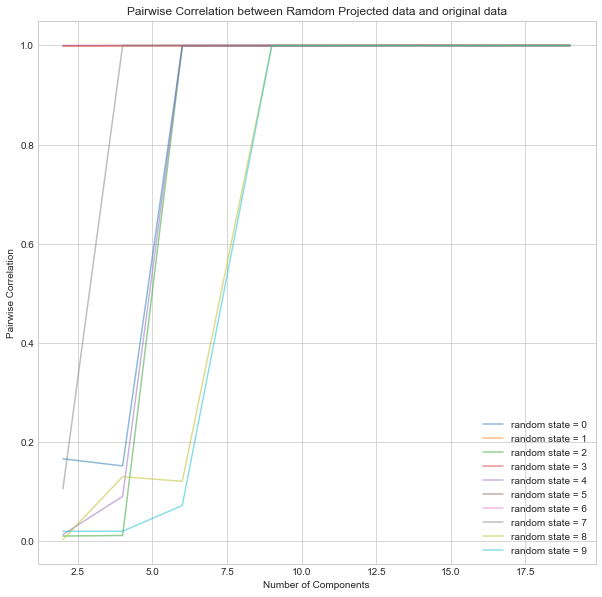

In [145]:
plt.figure(figsize=(10,10))
#sns.set_style("whitegrid")
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
for i in range(10):
    plt.plot(dims, tmp[i], alpha=0.5, label = 'random state = ' + str(i))
    #plt.plot(clusters, SSE_ica['ica'],  alpha=0.5, label = 'ICA reduced', color = 'orange')
plt.title("Pairwise Correlation between Ramdom Projected data and original data")
plt.xlabel("Number of Components")
plt.ylabel("Pairwise Correlation")
plt.legend()
plt.show()

In [147]:
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors) 

In [148]:
tmp1 = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    rp.fit(train_x_hr)  
    tmp1[dim][i] = reconstructionError(rp, train_x_hr)
tmp1 =pd.DataFrame(tmp1).T

In [149]:
tmp1

,0,1,2,3,4,5,6,7,8,9
2,2.260186e+03,1.460344e+03,2.260429e+03,1.804006e+03,2260.248249,1.416809e+03,1.889929e+03,2259.978861,2.260423e+03,2.259677e+03
4,2.260217e+03,1.348732e+03,2.260223e+03,1.077488e+03,2259.929575,1.240028e+03,1.885011e+03,1672.692027,2.260216e+03,2.259664e+03
6,1.839386e+03,1.236216e+03,1.458435e+03,1.041988e+03,1549.162273,1.114501e+03,1.878600e+03,1530.959943,2.260156e+03,2.259401e+03
9,1.224577e+03,4.529280e+02,1.285224e+03,3.555429e+02,1243.352824,7.167059e+02,1.171726e+03,913.320506,1.470273e+03,1.761713e+03
12,1.534337e+03,7.663265e+02,1.313250e+03,1.299739e+02,843.978028,5.824760e+02,1.007178e+03,390.511957,2.134026e+02,1.416306e+03
14,1.297765e+03,2.025768e+02,6.823034e+02,4.340645e+01,595.414976,2.627799e+02,8.759326e+02,481.743053,4.229730e+02,1.380927e+03
16,6.098098e+02,2.960116e-01,5.222114e+02,6.746460e+01,336.292247,4.528853e+01,2.958287e+02,125.309278,5.247598e+02,2.340313e+02
19,3.194175e-26,3.404319e-26,1.042195e-26,5.251081e-26,54.266376,3.880054e-26,3.700786e-26,0.002593,2.345529e-26,1.871554e-26


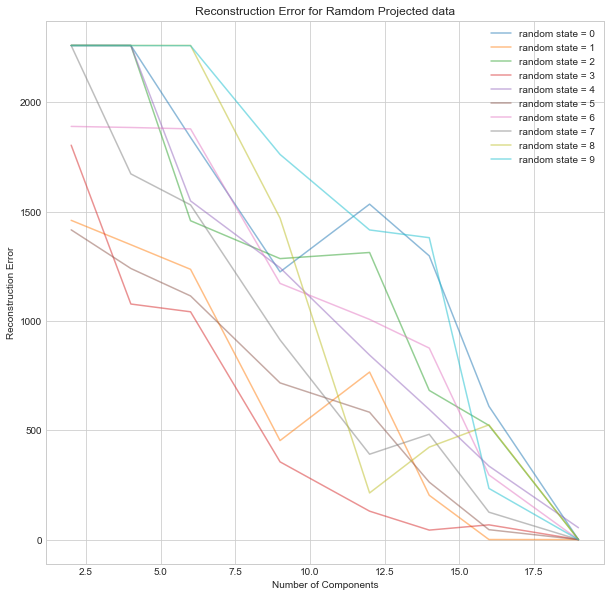

In [152]:
plt.figure(figsize=(10,10))
#sns.set_style("whitegrid")
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
for i in range(10):
    plt.plot(dims, tmp1[i], alpha=0.5, label = 'random state = ' + str(i))
    #plt.plot(clusters, SSE_ica['ica'],  alpha=0.5, label = 'ICA reduced', color = 'orange')
plt.title("Reconstruction Error for Ramdom Projected data")
plt.xlabel("Number of Components")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

In [162]:
SSE_rp = defaultdict(dict)
ll_rp = defaultdict(dict)
#adjMI_pca = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=10)
gmm = GMM(random_state=10) # Gaussian Matrix
km_rp = kmeans(random_state=10)
gmm_rp = GMM(random_state=10) # Gaussian Matrix
x_rp = rp.fit_transform(train_x_hr)
for k in clusters:
        km.set_params(n_clusters=k, random_state=10)
        #km_rp.set_params(n_clusters=k, random_state=10)
        gmm.set_params(n_components=k, random_state=10)
        #gmm_rp.set_params(n_components=k, random_state=10)        
        km.fit(train_x_hr)
        #km_rp.fit(x_rp)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        gmm.fit(train_x_hr)
        #gmm_rp.fit(x_rp)
        SSE_rp[k]['original'] = km.score(train_x_hr)
        #SSE_rp[k]['rp'] = km_rp.score(x_rp)
        ll_rp[k]['original'] = gmm.score(train_x_hr) 
        #ll_rp[k]['rp'] = gmm_rp.score(x_rp)    

for k in clusters:
    for i in range(10):
        #km.set_params(n_clusters=k, random_state=i)
        km_rp.set_params(n_clusters=k, random_state=i)
        #gmm.set_params(n_components=k, random_state=i)
        gmm_rp.set_params(n_components=k, random_state=i)        
        #km.fit(train_x_hr)
        km_rp.fit(x_rp)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        #gmm.fit(train_x_hr)
        gmm_rp.fit(x_rp)
        #SSE_rp[k]['original'] = km.score(train_x_hr)
        SSE_rp[k]['rp' + str(i)] = km_rp.score(x_rp)
        #ll_rp[k]['original'] = gmm.score(train_x_hr) 
        ll_rp[k]['rp' + str(i)] = gmm_rp.score(x_rp)    


In [165]:
SSE_rp = (-pd.DataFrame(SSE_rp)).T
#SSE_pca.rename(columns = lambda x: x+' SSE (left)',inplace=True)
ll_rp = pd.DataFrame(ll_rp).T

In [166]:
SSE_rp

,original,rp0,rp1,rp2,rp3,rp4,rp5,rp6,rp7,rp8,rp9
2,8.873111e+06,6.228598e+06,6.228598e+06,6.228598e+06,6.228598e+06,6.228598e+06,6.228598e+06,6.228598e+06,6.228598e+06,6.228598e+06,6.228598e+06
5,1.986862e+06,1.411328e+06,1.411482e+06,1.411460e+06,1.411667e+06,1.411507e+06,1.411619e+06,1.411614e+06,1.411885e+06,1.411963e+06,1.411963e+06
10,5.662148e+05,4.082048e+05,4.080457e+05,4.083631e+05,4.084914e+05,4.082633e+05,4.083469e+05,4.095003e+05,4.094223e+05,4.083674e+05,4.081627e+05
15,2.928662e+05,2.154040e+05,2.148900e+05,2.151386e+05,2.150155e+05,2.148389e+05,2.152195e+05,2.148771e+05,2.152622e+05,2.148360e+05,2.149994e+05
20,1.965386e+05,1.496939e+05,1.498022e+05,1.499988e+05,1.499816e+05,1.504123e+05,1.495952e+05,1.503740e+05,1.497013e+05,1.497773e+05,1.500095e+05
25,1.515891e+05,1.176512e+05,1.179727e+05,1.176872e+05,1.174299e+05,1.182734e+05,1.176944e+05,1.184101e+05,1.184754e+05,1.174740e+05,1.175415e+05
30,1.278228e+05,1.002861e+05,1.005914e+05,1.015718e+05,1.002420e+05,1.003355e+05,1.011086e+05,1.010630e+05,1.002066e+05,1.006372e+05,1.009473e+05
35,1.124192e+05,9.113095e+04,9.189693e+04,9.147004e+04,9.125034e+04,9.202071e+04,9.137635e+04,9.135381e+04,9.134753e+04,9.147747e+04,9.132568e+04
40,1.038534e+05,8.472494e+04,8.476162e+04,8.475630e+04,8.484367e+04,8.493583e+04,8.505915e+04,8.459174e+04,8.501837e+04,8.489018e+04,8.507271e+04
45,9.647982e+04,7.946869e+04,7.942288e+04,7.971582e+04,7.945390e+04,7.980653e+04,7.949368e+04,7.983137e+04,7.966676e+04,8.010576e+04,7.957313e+04


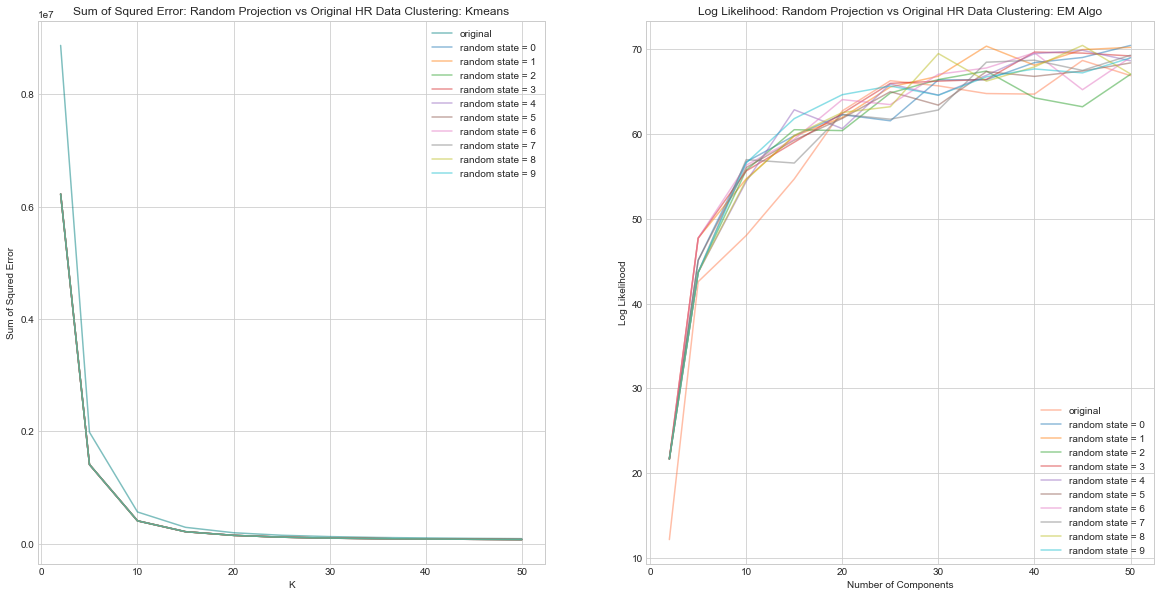

In [169]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, SSE_rp['original'],  alpha=0.5, label = 'original', color = 'teal')
for i in range(10):
    plt.plot(clusters, SSE_rp['rp'+str(i)],  alpha=0.5, label = 'random state = ' + str(i))
plt.title("Sum of Squred Error: Random Projection vs Original HR Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Sum of Squred Error")
plt.legend()
plt.subplot(122)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, ll_ica['original'], alpha=0.5, label = 'original', color = 'coral')
for i in range(10):
    plt.plot(clusters, ll_rp['rp'+str(i)],  alpha=0.5, label = 'random state = ' + str(i))
plt.title("Log Likelihood: Random Projection vs Original HR Data Clustering: EM Algo")
plt.xlabel("Number of Components")
plt.ylabel("Log Likelihood")
plt.legend()

plt.show()

4. Random Forest

In [156]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from helpers import   nn_arch,nn_reg,ImportanceSelect
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


In [154]:
class ImportanceSelect(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
        self.model = model
        self.n = n
    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self
    def transform(self, X):
        return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]

In [158]:
#rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=7)
forest = RandomForestRegressor(200)
forest.fit(train_x_hr,train_y_hr)
fs = forest.feature_importances_ 
tmp2 = pd.Series(np.sort(fs)[::-1])
fs

array([0.17177602, 0.35638719, 0.2431868 , 0.06068806, 0.0175264 ,
       0.00468284, 0.01026266, 0.00885295, 0.00822781, 0.00718288,
       0.00633803, 0.00899044, 0.00934067, 0.01722771, 0.01506819,
       0.01527839, 0.01014793, 0.01459038, 0.01424466])

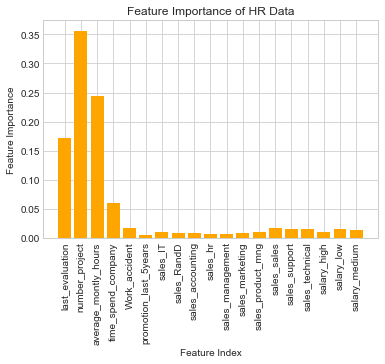

In [161]:
plt.figure()
plt.bar(train_x_hr.columns, fs, align='center', color = 'orange')
plt.ylabel('Feature Importance')
plt.xlabel('Feature Index')
plt.title('Feature Importance of HR Data')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [163]:
train_x_hr.columns

Index(['last_evaluation', 'number_project', 'average_montly_hours',
       'time_spend_company', 'Work_accident', 'promotion_last_5years',
       'sales_IT', 'sales_RandD', 'sales_accounting', 'sales_hr',
       'sales_management', 'sales_marketing', 'sales_product_mng',
       'sales_sales', 'sales_support', 'sales_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

In [167]:
rf_x = train_x_hr[['last_evaluation', 'number_project', 'average_montly_hours',
       'time_spend_company']]

In [168]:
rf_x.head()

,last_evaluation,number_project,average_montly_hours,time_spend_company
0,0.53,2,157,3
1,0.86,5,262,6
2,0.88,7,272,4
3,0.87,5,223,5
4,0.52,2,159,3


In [170]:
SSE_rf = defaultdict(dict)
ll_rf = defaultdict(dict)
#adjMI_pca = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=10)
gmm = GMM(random_state=10) # Gaussian Matrix
km_rf = kmeans(random_state=10)
gmm_rf = GMM(random_state=10) # Gaussian Matrix

for k in clusters:
        km.set_params(n_clusters=k, random_state=10)
        km_rf.set_params(n_clusters=k, random_state=10)
        gmm.set_params(n_components=k, random_state=10)
        gmm_rf.set_params(n_components=k, random_state=10)
        
        km.fit(train_x_hr)
        km_rf.fit(rf_x)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        gmm.fit(train_x_hr)
        gmm_rf.fit(rf_x)
        SSE_rf[k]['original'] = km.score(train_x_hr)
        SSE_rf[k]['rf'] = km_rf.score(rf_x)
        ll_rf[k]['original'] = gmm.score(train_x_hr) 
        ll_rf[k]['rf'] = gmm_rf.score(rf_x)    



In [172]:
SSE_rf = (-pd.DataFrame(SSE_rf)).T
#SSE_pca.rename(columns = lambda x: x+' SSE (left)',inplace=True)
ll_rf = pd.DataFrame(ll_rf).T

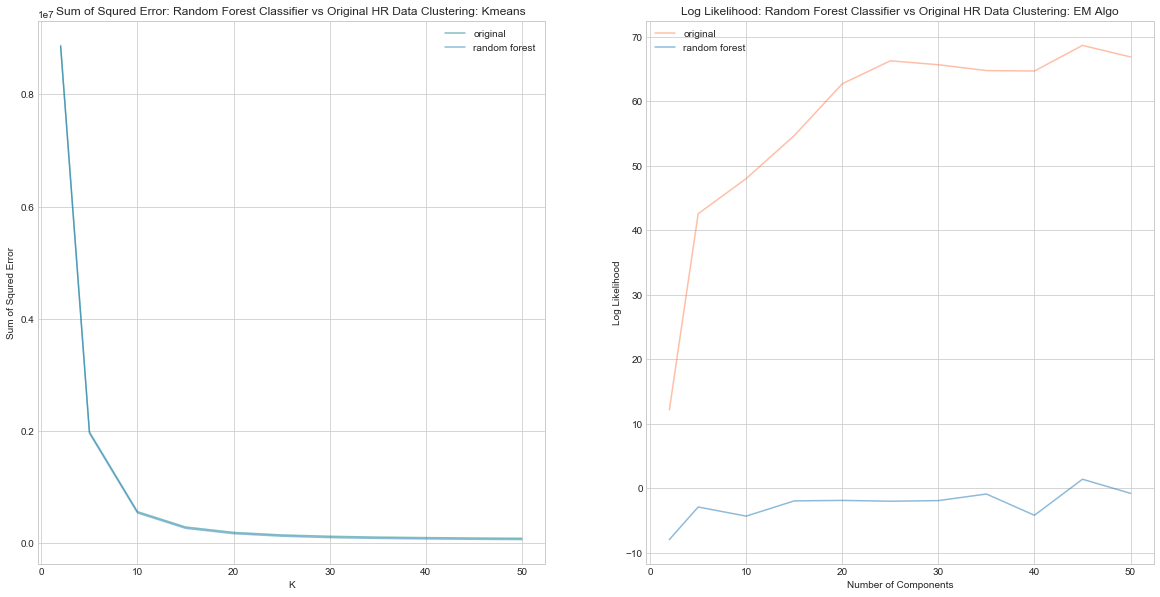

In [173]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(clusters, SSE_rf['original'],  alpha=0.5, label = 'original', color = 'teal')
plt.plot(clusters, SSE_rf['rf'],  alpha=0.5, label = 'random forest')
plt.title("Sum of Squred Error: Random Forest Classifier vs Original HR Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Sum of Squred Error")
plt.legend()
plt.subplot(122)
plt.plot(clusters, ll_rf['original'], alpha=0.5, label = 'original', color = 'coral')
plt.plot(clusters, ll_rf['rf'],  alpha=0.5, label = 'random forest')
plt.title("Log Likelihood: Random Forest Classifier vs Original HR Data Clustering: EM Algo")
plt.xlabel("Number of Components")
plt.ylabel("Log Likelihood")
plt.legend()

plt.show()

In [ ]:
# save all the DR dataset and apply NN
# 1. original dataset + kmeans/em label
km = kmeans(random_state=10)
gmm = GMM(random_state=10) # Gaussian Matrix
km.fit(train_x_hr)
gmm.fit(train_x_hr)
km_y = km.predict(train_x_hr)
gmm_y = gmm.predict(train_x_hr)
temp = train_x_hr.copy(deep = True)
temp['kmeans'] = km_y
temp['em'] = gmm_y
temp

In [180]:
temp.head()

,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_RandD,sales_accounting,sales_hr,...,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium,kmeans,em
0,0.53,2,157,3,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,0.86,5,262,6,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,6,0
2,0.88,7,272,4,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,6,0
3,0.87,5,223,5,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,2,0
4,0.52,2,159,3,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0


In [181]:
# save all the DR dataset and apply NN
temp.to_pickle("originalLabel")

In [185]:
np.save('pca_hr.npy',reduced_hr_data)

In [186]:
np.save('ica_hr.npy', S)

In [188]:
rp = SparseRandomProjection(random_state=10, n_components=10)
x_rp = rp.fit_transform(train_x_hr)
np.save('rp_hr.npy', x_rp)

In [190]:
np.save('rf_hr.npy', rf_x)

Neural Network on DR dataset

In [23]:
#Keras_NN_Classifier: deep feed-forward network with categorical crossentropy objective.
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

In [9]:
# load all the saved data

origin = pd.read_pickle("originalLabel")


In [10]:
pca_hr = np.load('pca_hr.npy')

In [11]:
ica_hr = np.load('ica_hr.npy')

In [12]:
rp_hr = np.load('rp_hr.npy')

In [13]:
rf_hr = np.load('rf_hr.npy')

run NN at each of the dataset and compare it to the original result (time and accuracy)

In [14]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.arange(1000, 11000, 1000)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("sample size")
    plt.ylabel("Mean square error")
    plt.legend(loc="best")
    return plt


In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_x_hr, train_y_hr, random_state=0)

In [29]:
def create_baseline():
    # create model
    model = Sequential()
    dim = train_x_hr.shape[1]
    model.add(Dense(60, input_dim=dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [34]:
st = clock()
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=create_baseline, nb_epoch=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(estimator, train_x_hr, train_y_hr, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print("Elapsed Time:" + str(clock()-st))

Results: -6.41% (0.24%)
Elapsed Time:21.542699000000002


In [36]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(
estimator, train_x_hr, train_y_hr, train_sizes=np.arange(1000, 11000, 1000), cv=5)
train_sizes          

array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000])

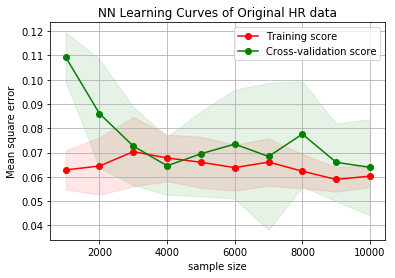

In [42]:
train_scores_mean = -1*np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -1*np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.figure()
plt.title("NN Learning Curves of Original HR data")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("sample size")
plt.ylabel("Mean square error")
plt.legend(loc="best")


In [21]:
def create_pca_baseline():
    # create model
    model = Sequential()
    dim = pca_hr.shape[1]
    model.add(Dense(60, input_dim=dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

Elapsed Time:199.724098


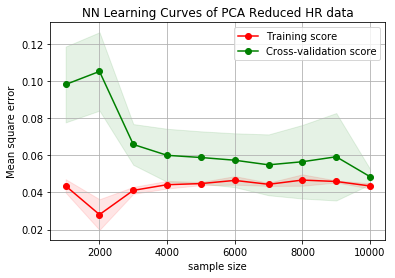

In [24]:
st = clock()
title = "NN Learning Curves of PCA reduced HR data"
estimator = KerasRegressor(build_fn=create_pca_baseline, nb_epoch=100, batch_size=5, verbose=0)
#plot_learning_curve(estimator, title, pca_hr, train_y_hr, cv=5, n_jobs=4)
train_sizes, train_scores, valid_scores = learning_curve(
estimator, pd.DataFrame(pca_hr), train_y_hr, train_sizes=np.arange(1000, 11000, 1000), cv=5)
print("Elapsed Time:" + str(clock()-st))
train_sizes 
train_scores_mean = -1*np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -1*np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.figure()
plt.title("NN Learning Curves of PCA Reduced HR data")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("sample size")
plt.ylabel("Mean square error")
plt.legend(loc="best")
plt.show()

In [26]:
def create_ica_baseline():
    # create model
    model = Sequential()
    dim = ica_hr.shape[1]
    model.add(Dense(60, input_dim=dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

Elapsed Time:292.165976


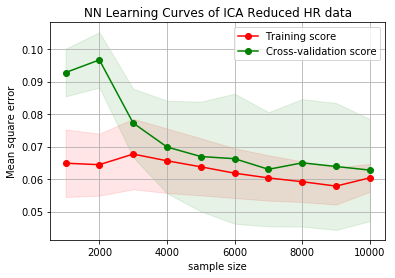

In [28]:
st = clock()
title = "NN Learning Curves of ICA reduced HR data"
estimator = KerasRegressor(build_fn=create_ica_baseline, nb_epoch=100, batch_size=5, verbose=0)
#plot_learning_curve(estimator, title, pca_hr, train_y_hr, cv=5, n_jobs=4)
train_sizes, train_scores, valid_scores = learning_curve(
estimator, pd.DataFrame(ica_hr), train_y_hr, train_sizes=np.arange(1000, 11000, 1000), cv=5)
print("Elapsed Time:" + str(clock()-st))
train_sizes 
train_scores_mean = -1*np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -1*np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.figure()
plt.title("NN Learning Curves of ICA Reduced HR data")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("sample size")
plt.ylabel("Mean square error")
plt.legend(loc="best")
plt.show()

In [29]:
def create_rp_baseline():
    # create model
    model = Sequential()
    dim = rp_hr.shape[1]
    model.add(Dense(60, input_dim=dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

Elapsed Time:405.88374200000004


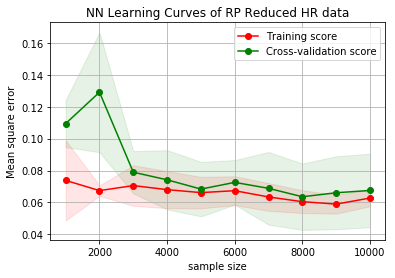

In [31]:
st = clock()
title = "NN Learning Curves of RP reduced HR data"
estimator = KerasRegressor(build_fn=create_rp_baseline, nb_epoch=100, batch_size=5, verbose=0)
#plot_learning_curve(estimator, title, pca_hr, train_y_hr, cv=5, n_jobs=4)
train_sizes, train_scores, valid_scores = learning_curve(
estimator, pd.DataFrame(rp_hr), train_y_hr, train_sizes=np.arange(1000, 11000, 1000), cv=5)
print("Elapsed Time:" + str(clock()-st))
train_sizes 
train_scores_mean = -1*np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -1*np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.figure()
plt.title("NN Learning Curves of RP Reduced HR data")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("sample size")
plt.ylabel("Mean square error")
plt.legend(loc="best")
plt.show()

In [33]:
def create_rf_baseline():
    # create model
    model = Sequential()
    dim = rf_hr.shape[1]
    model.add(Dense(60, input_dim=dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

Elapsed Time:546.855727


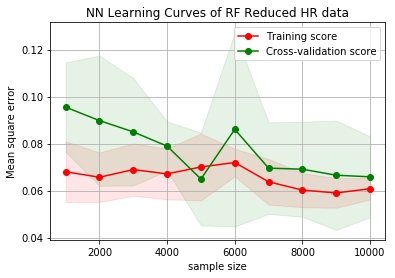

In [34]:
st = clock()
title = "NN Learning Curves of RF reduced HR data"
estimator = KerasRegressor(build_fn=create_rf_baseline, nb_epoch=100, batch_size=5, verbose=0)
#plot_learning_curve(estimator, title, pca_hr, train_y_hr, cv=5, n_jobs=4)
train_sizes, train_scores, valid_scores = learning_curve(
estimator, pd.DataFrame(rf_hr), train_y_hr, train_sizes=np.arange(1000, 11000, 1000), cv=5)
print("Elapsed Time:" + str(clock()-st))
train_sizes 
train_scores_mean = -1*np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -1*np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.figure()
plt.title("NN Learning Curves of RF Reduced HR data")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("sample size")
plt.ylabel("Mean square error")
plt.legend(loc="best")
plt.show()

In [43]:
label1 = origin.columns
origin_kmeans = origin.drop(["em"], axis = 1)
origin_kmeans.columns                            

Index(['last_evaluation', 'number_project', 'average_montly_hours',
       'time_spend_company', 'Work_accident', 'promotion_last_5years',
       'sales_IT', 'sales_RandD', 'sales_accounting', 'sales_hr',
       'sales_management', 'sales_marketing', 'sales_product_mng',
       'sales_sales', 'sales_support', 'sales_technical', 'salary_high',
       'salary_low', 'salary_medium', 'kmeans'],
      dtype='object')

In [44]:
origin_em = origin.drop(["kmeans"], axis = 1)
origin_em.columns   

Index(['last_evaluation', 'number_project', 'average_montly_hours',
       'time_spend_company', 'Work_accident', 'promotion_last_5years',
       'sales_IT', 'sales_RandD', 'sales_accounting', 'sales_hr',
       'sales_management', 'sales_marketing', 'sales_product_mng',
       'sales_sales', 'sales_support', 'sales_technical', 'salary_high',
       'salary_low', 'salary_medium', 'em'],
      dtype='object')

Text(0.5,1,'HR Data: Clusters')

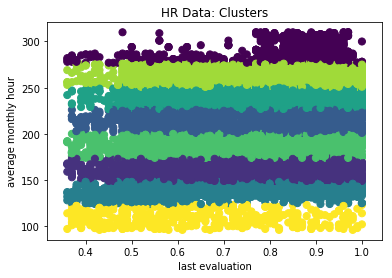

In [50]:
plt.scatter(origin_kmeans['last_evaluation'], origin_kmeans['average_montly_hours'], c=origin_kmeans['kmeans'], s=50, cmap='viridis')
plt.xlabel("last evaluation")
plt.ylabel("average monthly hour")
plt.title("HR Data: Clusters")

In [51]:
def create_label_baseline():
    # create model
    model = Sequential()
    dim = origin_kmeans.shape[1]
    model.add(Dense(60, input_dim=dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

Elapsed Time:649.4177910000001


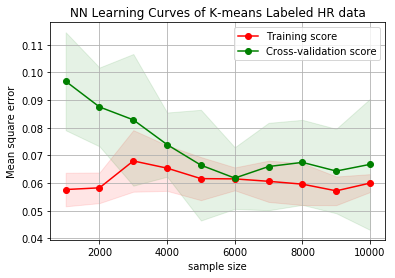

In [52]:
st = clock()
title = "NN Learning Curves of K-means Labeled HR data"
estimator = KerasRegressor(build_fn=create_label_baseline, nb_epoch=100, batch_size=5, verbose=0)
#plot_learning_curve(estimator, title, pca_hr, train_y_hr, cv=5, n_jobs=4)
train_sizes, train_scores, valid_scores = learning_curve(
estimator, pd.DataFrame(origin_kmeans), train_y_hr, train_sizes=np.arange(1000, 11000, 1000), cv=5)
print("Elapsed Time:" + str(clock()-st))
train_sizes 
train_scores_mean = -1*np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -1*np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.figure()
plt.title("NN Learning Curves of K-means Labeled HR data")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("sample size")
plt.ylabel("Mean square error")
plt.legend(loc="best")
plt.show()

In [53]:
def create_em_baseline():
    # create model
    model = Sequential()
    dim = origin_em.shape[1]
    model.add(Dense(60, input_dim=dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

Elapsed Time:808.14453


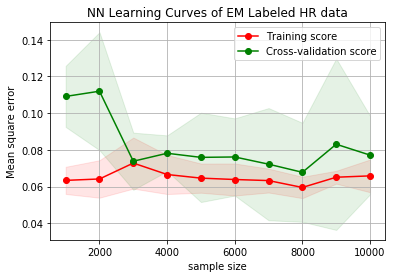

In [54]:
st = clock()
title = "NN Learning Curves of EM Labeled HR data"
estimator = KerasRegressor(build_fn=create_em_baseline, nb_epoch=100, batch_size=5, verbose=0)
#plot_learning_curve(estimator, title, pca_hr, train_y_hr, cv=5, n_jobs=4)
train_sizes, train_scores, valid_scores = learning_curve(
estimator, pd.DataFrame(origin_em), train_y_hr, train_sizes=np.arange(1000, 11000, 1000), cv=5)
print("Elapsed Time:" + str(clock()-st))
train_sizes 
train_scores_mean = -1*np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -1*np.mean(valid_scores, axis=1)
test_scores_std = np.std(valid_scores, axis=1)
plt.figure()
plt.title("NN Learning Curves of EM Labeled HR data")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("sample size")
plt.ylabel("Mean square error")
plt.legend(loc="best")
plt.show()